# Project Final


## Using Google Drive

Start by saving this Notebook to your Google Drive account. Then go to your Google Drive, click on the Colab Notebooks folder to find
You'll have to log into Google Drive this way if you want to load your dataset or save save your work as a new dataset.

In [ ]:
# Mount your Google Drive. It will prompt you to log into your Google account.
from google.colab import drive
drive.mount('/content/drive')

import os

drive_path = '/content/drive/MyDrive/Colab Notebooks/'
project_folder = 'Econ_0150_Project'

os.chdir(drive_path + project_folder)

print("Current folder:", os.getcwd())
print("Files here:", os.listdir())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current folder: /content/drive/MyDrive/Colab Notebooks/Econ_0150_Project
Files here: ['Second_Generation_wages.csv.gz', 'cleaned_immigrant_wage_data.csv', 'Asanbe_FinalP.docx']


In [ ]:
# Change the working directory to project folder.
import os
drive_path = '/content/drive/MyDrive/Colab Notebooks/'
project_folder = 'Econ_0150_Project/'
os.chdir(drive_path + project_folder)

## Step 0 | Imports and Setup

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [ ]:
# Open a dataset from your project folder in Google Drive
data = pd.read_csv('Second_Generation_wages.csv.gz')
(data.head())

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,PERNUM,WTFINL,CPSIDP,CPSIDV,ASECWT,AGE,MBPL,FBPL,NATIVITY,EDUC,INCWAGE
0,2009,1,3,NaN,20071202814500,1.0,NaN,534.34,1,NaN,20071202814501,200712028145011,534.34,56,9900,9900,1,81,34000.0
1,2009,1,3,NaN,20071202814500,1.0,NaN,534.34,2,NaN,20071202814502,200712028145021,534.34,59,9900,9900,1,123,100000.0
2,2009,2,3,NaN,20071202885100,1.0,NaN,546.24,1,NaN,20071202885101,200712028851011,546.24,49,9900,9900,1,73,16000.0
3,2009,2,3,NaN,20071202885100,1.0,NaN,546.24,2,NaN,20071202885102,200712028851021,546.24,52,9900,9900,1,73,146000.0
4,2009,3,3,NaN,20071202862500,1.0,NaN,287.76,1,NaN,20071202862501,200712028625011,287.76,35,9900,9900,1,123,39350.0


## Step 1 | Data Preparation

Turn your data into something you can explore through data operations.

In [ ]:
# Step 1 | Data Preparation

# Load data
data = pd.read_csv('Second_Generation_wages.csv.gz')

# Keep only variables needed
data = data[['YEAR', 'AGE', 'EDUC', 'INCWAGE', 'NATIVITY']].copy()

# Keep native-born (1) and immigrants (2)
data = data[data['NATIVITY'].isin([1, 2])].copy()

# Restrict to recent years
data = data[data['YEAR'] >= 2015].copy()

# Keep positive wages
data = data[data['INCWAGE'] > 0].copy()

# Restrict to working-age population
data = data[(data['AGE'] >= 18) & (data['AGE'] <= 65)].copy()

# Create wage variables
data['log_wage'] = np.log(data['INCWAGE'])
data['wage_dollars'] = data['INCWAGE']

# Create immigrant indicator
data['immigrant'] = (data['NATIVITY'] == 2).astype(int)
data['immigrant_label'] = np.where(
    data['immigrant'] == 1, 'Immigrant', 'Native-born'
)

# Check sample
print("Rows after cleaning:", len(data))
print("Years in sample:", data['YEAR'].min(), "to", data['YEAR'].max())
print(data['immigrant_label'].value_counts())




Rows after cleaning: 536569
Years in sample: 2015 to 2025
immigrant_label
Native-born    522946
Immigrant       13623
Name: count, dtype: int64


In [ ]:
# Save your dataset after you've worked on it
data.to_csv('cleaned_immigrant_wage_data.csv', index=False)

## Step 2 | Exploratory Data Analysis

Summarize the main variables and relationships of interest.

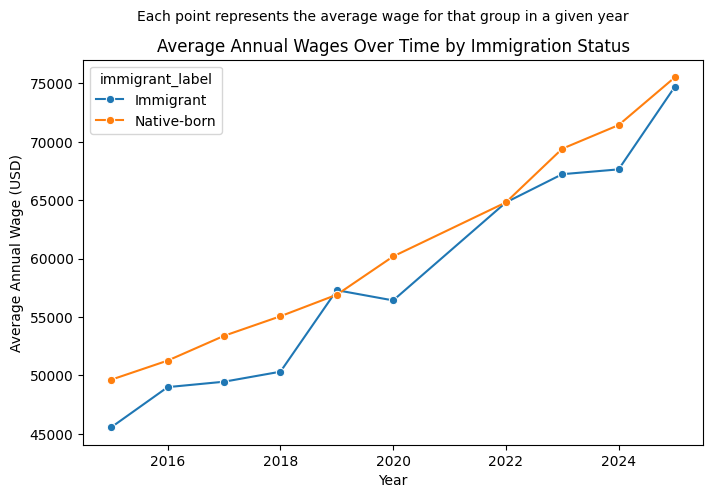

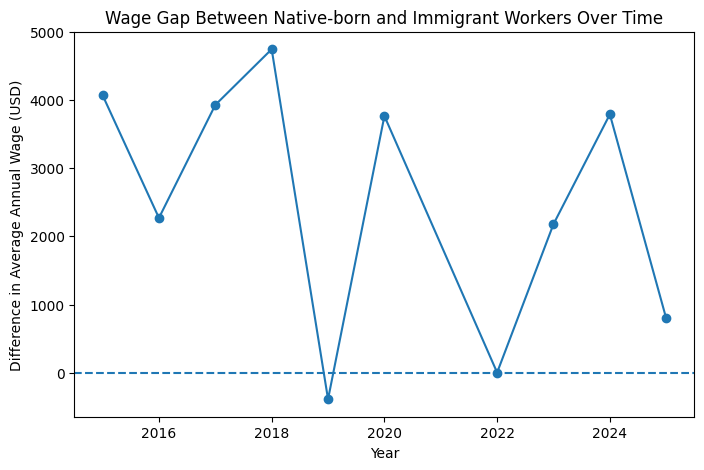

In [ ]:

# Exploratory Data Analysis

# Graph 1: Average annual wages over time by group

yearly_avg = (
    data
    .groupby(['YEAR', 'immigrant_label'])['wage_dollars']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=yearly_avg,
    x='YEAR',
    y='wage_dollars',
    hue='immigrant_label',
    marker='o'
)

plt.xlabel('Year')
plt.ylabel('Average Annual Wage (USD)')
plt.title('Average Annual Wages Over Time by Immigration Status')
plt.suptitle('Each point represents the average wage for that group in a given year', fontsize=10)
plt.show()


# Graph 2: Wage gap over time (Native-born − Immigrant)

yearly_avg_wide = yearly_avg.pivot(
    index='YEAR',
    columns='immigrant_label',
    values='wage_dollars'
)

yearly_avg_wide['Wage Gap (Native-born − Immigrant)'] = (
    yearly_avg_wide['Native-born'] - yearly_avg_wide['Immigrant']
)

plt.figure(figsize=(8,5))
plt.plot(
    yearly_avg_wide.index,
    yearly_avg_wide['Wage Gap (Native-born − Immigrant)'],
    marker='o'
)

plt.axhline(0, linestyle='--')
plt.xlabel('Year')
plt.ylabel('Difference in Average Annual Wage (USD)')
plt.title('Wage Gap Between Native-born and Immigrant Workers Over Time')
plt.show()

## Step 3 (Part 3 - 5)

Develop your statistical model.

1. Write down you null hypothesis
2. Write down your statistical model
3. Run your statistical model
4. Visualize your statistical model (if appropriate)

In [ ]:
# Build and run your model here

# 1. Null Hypothesis
# H0: There is no difference in wages between immigrants and native-born workers,
# controlling for education, age, and year (β_immigrant = 0).


# 2. Statistical Model
# log(wage)_i = β0 + β1*Immigrant_i + β2*EDUC_i + β3*AGE_i + β4*YEAR_i + ε_i


# 3. Run the statistical model (OLS regression)
model = smf.ols(
    'log_wage ~ immigrant + EDUC + AGE + YEAR',
    data=data
).fit()

print(model.summary())

# Interpretation of key coefficient
beta = model.params['immigrant']
pval = model.pvalues['immigrant']

print(f"Immigrant coefficient: {beta:.4f}")
print(f"Approximate percent difference: {100*beta:.2f}%")
print(f"P-value: {pval:.3f}")




                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                 3.517e+04
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:26:36   Log-Likelihood:            -7.4872e+05
No. Observations:              536569   AIC:                         1.497e+06
Df Residuals:                  536564   BIC:                         1.497e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.7524      0.827    -92.776      0.0

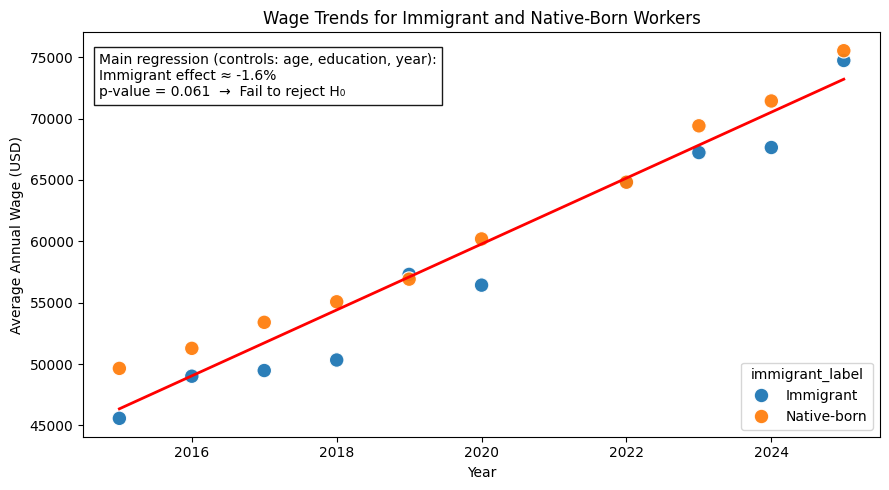

In [ ]:
# ------------------------------------------------------------
# Two-color scatter (yearly averages) + ONE regression line
# 1) Compute yearly average wages by immigration status
binned = (
    data
    .groupby(['YEAR', 'immigrant_label'])['wage_dollars']
    .mean()
    .reset_index()
)

#
binned['YEAR'] = pd.to_numeric(binned['YEAR'], errors='coerce')
binned = binned.dropna(subset=['YEAR', 'wage_dollars'])

plt.figure(figsize=(9,5))

# 2) Scatter points (two colors, mixed together)
sns.scatterplot(
    data=binned,
    x='YEAR',
    y='wage_dollars',
    hue='immigrant_label',
    s=110,
    alpha=0.95
)

# 3) ONE regression line across all points
sns.regplot(
    data=binned,
    x='YEAR',
    y='wage_dollars',
    scatter=False,
    ci=0,
    line_kws={'color': 'red', 'linewidth': 2}
)

plt.xlabel('Year')
plt.ylabel('Average Annual Wage (USD)')
plt.title('Wage Trends for Immigrant and Native-Born Workers')

# 4) Story box from main regression
beta = model.params['immigrant']
pval = model.pvalues['immigrant']
decision = "Reject H₀" if pval < 0.05 else "Fail to reject H₀"

story = (
    "Main regression (controls: age, education, year):\n"
    f"Immigrant effect ≈ {100*beta:.1f}%\n"
    f"p-value = {pval:.3f}  →  {decision}"
)

plt.text(
    0.02, 0.95, story,
    transform=plt.gca().transAxes,
    va='top',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.show()
